# StyleGAN 2 + DiffAugment for generation of COVID-19 CT Scans

Prepared by: Thanh Vo, Alex Brown, Justin Andronicos, Pradeep Jones

Unlike a traditional GAN, StyleGAN draws from two sources of randomness to generate a synthetic image. ​
* A mapping network which maps a point from latent space to a vector representing the "style" of the generated image​
* Noise is added at each layer to ensure variation at a pixel level​

**Style GAN 2**​
* Adaptive Instance Normalisation is removed and replaced with regular normalisation. ​
* Noise is added after normalisation​
* Modulisation operation is followed afterwards

**Diff Augment** 
* Differential augmentation technique that can be used to slightly augment the images

* Using Diff Augment, we can train a GAN to generate high quality images using only a dataset of 100 images

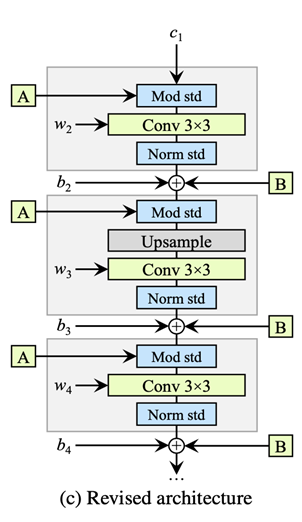


# How to Run


## Generate COVID CT scan images using StyleGAN 2
1.   Run the Environment setup code block
2.   Run the evaluation code block. Generated pictures should be displayed in the output of the last code block



# Environment setup

In [1]:
!pip install gdown

In [2]:
!git clone 'https://github.com/Ccamm/DoYouHaveCOVID-GIVEUSYOURCTSCANANDWECANTELLYOUFOR-10000AUD-DONTTRUSTYOURDOCTORS-YOUCANTRUSTUS-.git'

Cloning into 'DoYouHaveCOVID-GIVEUSYOURCTSCANANDWECANTELLYOUFOR-10000AUD-DONTTRUSTYOURDOCTORS-YOUCANTRUSTUS-'...
remote: Enumerating objects: 899, done.
remote: Total 899 (delta 0), reused 0 (delta 0), pack-reused 899
Receiving objects: 100% (899/899), 201.23 MiB | 23.58 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Checking out files: 100% (849/849), done.


In [3]:
%cd DoYouHaveCOVID-GIVEUSYOURCTSCANANDWECANTELLYOUFOR-10000AUD-DONTTRUSTYOURDOCTORS-YOUCANTRUSTUS-/stylegan2-pytorch/

/content/DoYouHaveCOVID-GIVEUSYOURCTSCANANDWECANTELLYOUFOR-10000AUD-DONTTRUSTYOURDOCTORS-YOUCANTRUSTUS-/stylegan2-pytorch


## Unzip CT COVID Train/Test Images

In [4]:
!git clone https://github.com/UCSD-AI4H/COVID-CT.git
!unzip /content/DoYouHaveCOVID-GIVEUSYOURCTSCANANDWECANTELLYOUFOR-10000AUD-DONTTRUSTYOURDOCTORS-YOUCANTRUSTUS-/stylegan2-pytorch/COVID-CT/Images-processed/CT_COVID.zip
!pip install Ninja

Cloning into 'COVID-CT'...
remote: Enumerating objects: 5459, done.
remote: Total 5459 (delta 0), reused 0 (delta 0), pack-reused 5459
Receiving objects: 100% (5459/5459), 1.09 GiB | 32.04 MiB/s, done.
Resolving deltas: 100% (360/360), done.
Checking out files: 100% (1048/1048), done.
Archive:  /content/DoYouHaveCOVID-GIVEUSYOURCTSCANANDWECANTELLYOUFOR-10000AUD-DONTTRUSTYOURDOCTORS-YOUCANTRUSTUS-/stylegan2-pytorch/COVID-CT/Images-processed/CT_COVID.zip
   creating: CT_COVID/
  inflating: CT_COVID/2020.03.01.20029769-p21-73_1%1.png  
   creating: __MACOSX/
   creating: __MACOSX/CT_COVID/
  inflating: __MACOSX/CT_COVID/._2020.03.01.20029769-p21-73_1%1.png  
  inflating: CT_COVID/Recurrence-of-positive-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%1.png  
  inflating: __MACOSX/CT_COVID/._Recurrence-of-positive-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%1.png  
  inflating: CT_COVID/2020.03.12.20034686-p17-91-4.png  
  inflating: __MACOSX/CT_COVID/._2020.03.1

## Download the Checkpoint

In [5]:
!gdown --id 1EL71wpKt0_tnc6ckOC5N4o__zrLpG5aB --output checkpoint/checkpoint.pt

Downloading...
From: https://drive.google.com/uc?id=1EL71wpKt0_tnc6ckOC5N4o__zrLpG5aB
To: /content/DoYouHaveCOVID-GIVEUSYOURCTSCANANDWECANTELLYOUFOR-10000AUD-DONTTRUSTYOURDOCTORS-YOUCANTRUSTUS-/stylegan2-pytorch/checkpoint/checkpoint.pt
829MB [00:03, 217MB/s]


# Training StyleGAN



*   Training time: 3 Days
*   Epochs: 50K
*   Learning rate: 0.002
*   Batch size: 16
*   Image size: 256x256





## Data Augmentation Function

In [11]:
# Differentiable Augmentation for Data-Efficient GAN Training
# Shengyu Zhao, Zhijian Liu, Ji Lin, Jun-Yan Zhu, and Song Han
# https://arxiv.org/pdf/2006.10738

import torch
import torch.nn.functional as F


def DiffAugment(x, policy='', channels_first=True):
    if policy:
        if not channels_first:
            x = x.permute(0, 3, 1, 2)
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if not channels_first:
            x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
    return x


def rand_brightness(x):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5)
    return x


def rand_saturation(x):
    x_mean = x.mean(dim=1, keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 2) + x_mean
    return x


def rand_contrast(x):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.5) + x_mean
    return x


def rand_translation(x, ratio=0.125):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2)
    return x


def rand_cutout(x, ratio=0.5):
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

## Generator and Discriminator Class

In [12]:
import math
import random
import functools
import operator

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Function

from op import FusedLeakyReLU, fused_leaky_relu, upfirdn2d


class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input * torch.rsqrt(torch.mean(input ** 2, dim=1, keepdim=True) + 1e-8)


def make_kernel(k):
    k = torch.tensor(k, dtype=torch.float32)

    if k.ndim == 1:
        k = k[None, :] * k[:, None]

    k /= k.sum()

    return k


class Upsample(nn.Module):
    def __init__(self, kernel, factor=2):
        super().__init__()

        self.factor = factor
        kernel = make_kernel(kernel) * (factor ** 2)
        self.register_buffer('kernel', kernel)

        p = kernel.shape[0] - factor

        pad0 = (p + 1) // 2 + factor - 1
        pad1 = p // 2

        self.pad = (pad0, pad1)

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, up=self.factor, down=1, pad=self.pad)

        return out


class Downsample(nn.Module):
    def __init__(self, kernel, factor=2):
        super().__init__()

        self.factor = factor
        kernel = make_kernel(kernel)
        self.register_buffer('kernel', kernel)

        p = kernel.shape[0] - factor

        pad0 = (p + 1) // 2
        pad1 = p // 2

        self.pad = (pad0, pad1)

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, up=1, down=self.factor, pad=self.pad)

        return out


class Blur(nn.Module):
    def __init__(self, kernel, pad, upsample_factor=1):
        super().__init__()

        kernel = make_kernel(kernel)

        if upsample_factor > 1:
            kernel = kernel * (upsample_factor ** 2)

        self.register_buffer('kernel', kernel)

        self.pad = pad

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, pad=self.pad)

        return out


class EqualConv2d(nn.Module):
    def __init__(
        self, in_channel, out_channel, kernel_size, stride=1, padding=0, bias=True
    ):
        super().__init__()

        self.weight = nn.Parameter(
            torch.randn(out_channel, in_channel, kernel_size, kernel_size)
        )
        self.scale = 1 / math.sqrt(in_channel * kernel_size ** 2)

        self.stride = stride
        self.padding = padding

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channel))

        else:
            self.bias = None

    def forward(self, input):
        out = F.conv2d(
            input,
            self.weight * self.scale,
            bias=self.bias,
            stride=self.stride,
            padding=self.padding,
        )

        return out

    def __repr__(self):
        return (
            f'{self.__class__.__name__}({self.weight.shape[1]}, {self.weight.shape[0]},'
            f' {self.weight.shape[2]}, stride={self.stride}, padding={self.padding})'
        )


class EqualLinear(nn.Module):
    def __init__(
        self, in_dim, out_dim, bias=True, bias_init=0, lr_mul=1, activation=None
    ):
        super().__init__()

        self.weight = nn.Parameter(torch.randn(out_dim, in_dim).div_(lr_mul))

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_dim).fill_(bias_init))

        else:
            self.bias = None

        self.activation = activation

        self.scale = (1 / math.sqrt(in_dim)) * lr_mul
        self.lr_mul = lr_mul

    def forward(self, input):
        if self.activation:
            out = F.linear(input, self.weight * self.scale)
            out = fused_leaky_relu(out, self.bias * self.lr_mul)

        else:
            out = F.linear(
                input, self.weight * self.scale, bias=self.bias * self.lr_mul
            )

        return out

    def __repr__(self):
        return (
            f'{self.__class__.__name__}({self.weight.shape[1]}, {self.weight.shape[0]})'
        )


class ScaledLeakyReLU(nn.Module):
    def __init__(self, negative_slope=0.2):
        super().__init__()

        self.negative_slope = negative_slope

    def forward(self, input):
        out = F.leaky_relu(input, negative_slope=self.negative_slope)

        return out * math.sqrt(2)


class ModulatedConv2d(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        style_dim,
        demodulate=True,
        upsample=False,
        downsample=False,
        blur_kernel=[1, 3, 3, 1],
    ):
        super().__init__()

        self.eps = 1e-8
        self.kernel_size = kernel_size
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.upsample = upsample
        self.downsample = downsample

        if upsample:
            factor = 2
            p = (len(blur_kernel) - factor) - (kernel_size - 1)
            pad0 = (p + 1) // 2 + factor - 1
            pad1 = p // 2 + 1

            self.blur = Blur(blur_kernel, pad=(pad0, pad1), upsample_factor=factor)

        if downsample:
            factor = 2
            p = (len(blur_kernel) - factor) + (kernel_size - 1)
            pad0 = (p + 1) // 2
            pad1 = p // 2

            self.blur = Blur(blur_kernel, pad=(pad0, pad1))

        fan_in = in_channel * kernel_size ** 2
        self.scale = 1 / math.sqrt(fan_in)
        self.padding = kernel_size // 2

        self.weight = nn.Parameter(
            torch.randn(1, out_channel, in_channel, kernel_size, kernel_size)
        )

        self.modulation = EqualLinear(style_dim, in_channel, bias_init=1)

        self.demodulate = demodulate

    def __repr__(self):
        return (
            f'{self.__class__.__name__}({self.in_channel}, {self.out_channel}, {self.kernel_size}, '
            f'upsample={self.upsample}, downsample={self.downsample})'
        )

    def forward(self, input, style):
        batch, in_channel, height, width = input.shape

        style = self.modulation(style).view(batch, 1, in_channel, 1, 1)
        weight = self.scale * self.weight * style

        if self.demodulate:
            demod = torch.rsqrt(weight.pow(2).sum([2, 3, 4]) + 1e-8)
            weight = weight * demod.view(batch, self.out_channel, 1, 1, 1)

        weight = weight.view(
            batch * self.out_channel, in_channel, self.kernel_size, self.kernel_size
        )

        if self.upsample:
            input = input.view(1, batch * in_channel, height, width)
            weight = weight.view(
                batch, self.out_channel, in_channel, self.kernel_size, self.kernel_size
            )
            weight = weight.transpose(1, 2).reshape(
                batch * in_channel, self.out_channel, self.kernel_size, self.kernel_size
            )
            out = F.conv_transpose2d(input, weight, padding=0, stride=2, groups=batch)
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)
            out = self.blur(out)

        elif self.downsample:
            input = self.blur(input)
            _, _, height, width = input.shape
            input = input.view(1, batch * in_channel, height, width)
            out = F.conv2d(input, weight, padding=0, stride=2, groups=batch)
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)

        else:
            input = input.view(1, batch * in_channel, height, width)
            out = F.conv2d(input, weight, padding=self.padding, groups=batch)
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)

        return out


class NoiseInjection(nn.Module):
    def __init__(self):
        super().__init__()

        self.weight = nn.Parameter(torch.zeros(1))

    def forward(self, image, noise=None):
        if noise is None:
            batch, _, height, width = image.shape
            noise = image.new_empty(batch, 1, height, width).normal_()

        return image + self.weight * noise


class ConstantInput(nn.Module):
    def __init__(self, channel, size=4):
        super().__init__()

        self.input = nn.Parameter(torch.randn(1, channel, size, size))

    def forward(self, input):
        batch = input.shape[0]
        out = self.input.repeat(batch, 1, 1, 1)

        return out


class StyledConv(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        style_dim,
        upsample=False,
        blur_kernel=[1, 3, 3, 1],
        demodulate=True,
    ):
        super().__init__()

        self.conv = ModulatedConv2d(
            in_channel,
            out_channel,
            kernel_size,
            style_dim,
            upsample=upsample,
            blur_kernel=blur_kernel,
            demodulate=demodulate,
        )

        self.noise = NoiseInjection()
        # self.bias = nn.Parameter(torch.zeros(1, out_channel, 1, 1))
        # self.activate = ScaledLeakyReLU(0.2)
        self.activate = FusedLeakyReLU(out_channel)

    def forward(self, input, style, noise=None):
        out = self.conv(input, style)
        out = self.noise(out, noise=noise)
        # out = out + self.bias
        out = self.activate(out)

        return out


class ToRGB(nn.Module):
    def __init__(self, in_channel, style_dim, upsample=True, blur_kernel=[1, 3, 3, 1]):
        super().__init__()

        if upsample:
            self.upsample = Upsample(blur_kernel)

        self.conv = ModulatedConv2d(in_channel, 3, 1, style_dim, demodulate=False)
        self.bias = nn.Parameter(torch.zeros(1, 3, 1, 1))

    def forward(self, input, style, skip=None):
        out = self.conv(input, style)
        out = out + self.bias

        if skip is not None:
            skip = self.upsample(skip)

            out = out + skip

        return out


class Generator(nn.Module):
    def __init__(
        self,
        size,
        style_dim,
        n_mlp,
        channel_multiplier=2,
        blur_kernel=[1, 3, 3, 1],
        lr_mlp=0.01,
    ):
        super().__init__()

        self.size = size

        self.style_dim = style_dim

        layers = [PixelNorm()]

        for i in range(n_mlp):
            layers.append(
                EqualLinear(
                    style_dim, style_dim, lr_mul=lr_mlp, activation='fused_lrelu'
                )
            )

        self.style = nn.Sequential(*layers)

        self.channels = {
            4: 512,
            8: 512,
            16: 512,
            32: 512,
            64: 256 * channel_multiplier,
            128: 128 * channel_multiplier,
            256: 64 * channel_multiplier,
            512: 32 * channel_multiplier,
            1024: 16 * channel_multiplier,
        }

        self.input = ConstantInput(self.channels[4])
        self.conv1 = StyledConv(
            self.channels[4], self.channels[4], 3, style_dim, blur_kernel=blur_kernel
        )
        self.to_rgb1 = ToRGB(self.channels[4], style_dim, upsample=False)

        self.log_size = int(math.log(size, 2))
        self.num_layers = (self.log_size - 2) * 2 + 1

        self.convs = nn.ModuleList()
        self.upsamples = nn.ModuleList()
        self.to_rgbs = nn.ModuleList()
        self.noises = nn.Module()

        in_channel = self.channels[4]

        for layer_idx in range(self.num_layers):
            res = (layer_idx + 5) // 2
            shape = [1, 1, 2 ** res, 2 ** res]
            self.noises.register_buffer(f'noise_{layer_idx}', torch.randn(*shape))

        for i in range(3, self.log_size + 1):
            out_channel = self.channels[2 ** i]

            self.convs.append(
                StyledConv(
                    in_channel,
                    out_channel,
                    3,
                    style_dim,
                    upsample=True,
                    blur_kernel=blur_kernel,
                )
            )

            self.convs.append(
                StyledConv(
                    out_channel, out_channel, 3, style_dim, blur_kernel=blur_kernel
                )
            )

            self.to_rgbs.append(ToRGB(out_channel, style_dim))

            in_channel = out_channel

        self.n_latent = self.log_size * 2 - 2

    def make_noise(self):
        device = self.input.input.device

        noises = [torch.randn(1, 1, 2 ** 2, 2 ** 2, device=device)]

        for i in range(3, self.log_size + 1):
            for _ in range(2):
                noises.append(torch.randn(1, 1, 2 ** i, 2 ** i, device=device))

        return noises

    def mean_latent(self, n_latent):
        latent_in = torch.randn(
            n_latent, self.style_dim, device=self.input.input.device
        )
        latent = self.style(latent_in).mean(0, keepdim=True)

        return latent

    def get_latent(self, input):
        return self.style(input)

    def forward(
        self,
        styles,
        return_latents=False,
        inject_index=None,
        truncation=1,
        truncation_latent=None,
        input_is_latent=False,
        noise=None,
        randomize_noise=True,
    ):
        if not input_is_latent:
            styles = [self.style(s) for s in styles]

        if noise is None:
            if randomize_noise:
                noise = [None] * self.num_layers
            else:
                noise = [
                    getattr(self.noises, f'noise_{i}') for i in range(self.num_layers)
                ]

        if truncation < 1:
            style_t = []

            for style in styles:
                style_t.append(
                    truncation_latent + truncation * (style - truncation_latent)
                )

            styles = style_t

        if len(styles) < 2:
            inject_index = self.n_latent

            if styles[0].ndim < 3:
                latent = styles[0].unsqueeze(1).repeat(1, inject_index, 1)

            else:
                latent = styles[0]

        else:
            if inject_index is None:
                inject_index = random.randint(1, self.n_latent - 1)

            latent = styles[0].unsqueeze(1).repeat(1, inject_index, 1)
            latent2 = styles[1].unsqueeze(1).repeat(1, self.n_latent - inject_index, 1)

            latent = torch.cat([latent, latent2], 1)

        out = self.input(latent)
        out = self.conv1(out, latent[:, 0], noise=noise[0])

        skip = self.to_rgb1(out, latent[:, 1])

        i = 1
        for conv1, conv2, noise1, noise2, to_rgb in zip(
            self.convs[::2], self.convs[1::2], noise[1::2], noise[2::2], self.to_rgbs
        ):
            out = conv1(out, latent[:, i], noise=noise1)
            out = conv2(out, latent[:, i + 1], noise=noise2)
            skip = to_rgb(out, latent[:, i + 2], skip)

            i += 2

        image = skip

        if return_latents:
            return image, latent

        else:
            return image, None


class ConvLayer(nn.Sequential):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        downsample=False,
        blur_kernel=[1, 3, 3, 1],
        bias=True,
        activate=True,
    ):
        layers = []

        if downsample:
            factor = 2
            p = (len(blur_kernel) - factor) + (kernel_size - 1)
            pad0 = (p + 1) // 2
            pad1 = p // 2

            layers.append(Blur(blur_kernel, pad=(pad0, pad1)))

            stride = 2
            self.padding = 0

        else:
            stride = 1
            self.padding = kernel_size // 2

        layers.append(
            EqualConv2d(
                in_channel,
                out_channel,
                kernel_size,
                padding=self.padding,
                stride=stride,
                bias=bias and not activate,
            )
        )

        if activate:
            if bias:
                layers.append(FusedLeakyReLU(out_channel))

            else:
                layers.append(ScaledLeakyReLU(0.2))

        super().__init__(*layers)


class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, blur_kernel=[1, 3, 3, 1]):
        super().__init__()

        self.conv1 = ConvLayer(in_channel, in_channel, 3)
        self.conv2 = ConvLayer(in_channel, out_channel, 3, downsample=True)

        self.skip = ConvLayer(
            in_channel, out_channel, 1, downsample=True, activate=False, bias=False
        )

    def forward(self, input):
        out = self.conv1(input)
        out = self.conv2(out)

        skip = self.skip(input)
        out = (out + skip) / math.sqrt(2)

        return out


class Discriminator(nn.Module):
    def __init__(self, size, channel_multiplier=2, blur_kernel=[1, 3, 3, 1]):
        super().__init__()

        channels = {
            4: 512,
            8: 512,
            16: 512,
            32: 512,
            64: 256 * channel_multiplier,
            128: 128 * channel_multiplier,
            256: 64 * channel_multiplier,
            512: 32 * channel_multiplier,
            1024: 16 * channel_multiplier,
        }

        convs = [ConvLayer(3, channels[size], 1)]

        log_size = int(math.log(size, 2))

        in_channel = channels[size]

        for i in range(log_size, 2, -1):
            out_channel = channels[2 ** (i - 1)]

            convs.append(ResBlock(in_channel, out_channel, blur_kernel))

            in_channel = out_channel

        self.convs = nn.Sequential(*convs)

        self.stddev_group = 4
        self.stddev_feat = 1

        self.final_conv = ConvLayer(in_channel + 1, channels[4], 3)
        self.final_linear = nn.Sequential(
            EqualLinear(channels[4] * 4 * 4, channels[4], activation='fused_lrelu'),
            EqualLinear(channels[4], 1),
        )

    def forward(self, input):
        out = self.convs(input)

        batch, channel, height, width = out.shape
        group = min(batch, self.stddev_group)
        stddev = out.view(
            group, -1, self.stddev_feat, channel // self.stddev_feat, height, width
        )
        stddev = torch.sqrt(stddev.var(0, unbiased=False) + 1e-8)
        stddev = stddev.mean([2, 3, 4], keepdims=True).squeeze(2)
        stddev = stddev.repeat(group, 1, height, width)
        out = torch.cat([out, stddev], 1)

        out = self.final_conv(out)

        out = out.view(batch, -1)
        out = self.final_linear(out)

        return out

## Training Helper Functions

In [13]:
import argparse
import math
import random
import os

import numpy as np
import torch
from torch import nn, autograd, optim
from torch.nn import functional as F
from torch.utils import data
import torch.distributed as dist
from torchvision import transforms, utils
from tqdm import tqdm
policy = 'color,translation,cutout' 
try:
    import wandb

except ImportError:
    wandb = None

from model import Generator, Discriminator
from distributed import (
    get_rank,
    synchronize,
    reduce_loss_dict,
    reduce_sum,
    get_world_size,
)
from non_leaking import augment


def data_sampler(dataset, shuffle, distributed):
    if distributed:
        return data.distributed.DistributedSampler(dataset, shuffle=shuffle)

    if shuffle:
        return data.RandomSampler(dataset)

    else:
        return data.SequentialSampler(dataset)


def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag


def accumulate(model1, model2, decay=0.999):
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())

    for k in par1.keys():
        par1[k].data.mul_(decay).add_(par2[k].data, alpha=1 - decay)


def sample_data(loader):
    while True:
        for batch in loader:
            yield batch


def d_logistic_loss(real_pred, fake_pred):
    real_loss = F.softplus(-real_pred)
    fake_loss = F.softplus(fake_pred)

    return real_loss.mean() + fake_loss.mean()


def d_r1_loss(real_pred, real_img):
    grad_real, = autograd.grad(
        outputs=real_pred.sum(), inputs=real_img, create_graph=True
    )
    grad_penalty = grad_real.pow(2).reshape(grad_real.shape[0], -1).sum(1).mean()

    return grad_penalty


def g_nonsaturating_loss(fake_pred):
    loss = F.softplus(-fake_pred).mean()

    return loss


def g_path_regularize(fake_img, latents, mean_path_length, decay=0.01):
    noise = torch.randn_like(fake_img) / math.sqrt(
        fake_img.shape[2] * fake_img.shape[3]
    )
    grad, = autograd.grad(
        outputs=(fake_img * noise).sum(), inputs=latents, create_graph=True
    )
    path_lengths = torch.sqrt(grad.pow(2).sum(2).mean(1))

    path_mean = mean_path_length + decay * (path_lengths.mean() - mean_path_length)

    path_penalty = (path_lengths - path_mean).pow(2).mean()

    return path_penalty, path_mean.detach(), path_lengths


def make_noise(batch, latent_dim, n_noise, device):
    if n_noise == 1:
        return torch.randn(batch, latent_dim, device=device)

    noises = torch.randn(n_noise, batch, latent_dim, device=device).unbind(0)

    return noises


def mixing_noise(batch, latent_dim, prob, device):
    if prob > 0 and random.random() < prob:
        return make_noise(batch, latent_dim, 2, device)

    else:
        return [make_noise(batch, latent_dim, 1, device)]


def set_grad_none(model, targets):
    for n, p in model.named_parameters():
        if n in targets:
            p.grad = None


def train(args, loader, generator, discriminator, g_optim, d_optim, g_ema, device):
    loader = sample_data(loader)

    pbar = range(args.iter)

    if get_rank() == 0:
        pbar = tqdm(pbar, initial=args.start_iter, dynamic_ncols=True, smoothing=0.01)

    mean_path_length = 0

    d_loss_val = 0
    r1_loss = torch.tensor(0.0, device=device)
    g_loss_val = 0
    path_loss = torch.tensor(0.0, device=device)
    path_lengths = torch.tensor(0.0, device=device)
    mean_path_length_avg = 0
    loss_dict = {}

    g_module = generator
    d_module = discriminator

    accum = 0.5 ** (32 / (10 * 1000))
    # ada_augment = torch.tensor([0.0, 0.0], device=device)
    # ada_aug_p = args.augment_p if args.augment_p > 0 else 0.0
    # ada_aug_step = args.ada_target / args.ada_length
    r_t_stat = 0

    sample_z = torch.randn(args.n_sample, args.latent, device=device)

    for idx in pbar:
        i = idx + args.start_iter

        if i > args.iter:
            print("Done!")

            break

        real_img = next(loader)
        real_img = real_img.to(device)

        requires_grad(generator, False)
        requires_grad(discriminator, True)

        noise = mixing_noise(args.batch, args.latent, args.mixing, device)
        fake_img, _ = generator(noise)

        if args.augment:
            real_img_aug  = DiffAugment(real_img, policy=policy)
            fake_img = DiffAugment(fake_img, policy=policy)

        else:
            real_img_aug = real_img

        fake_pred = discriminator(fake_img)
        real_pred = discriminator(real_img_aug)
        d_loss = d_logistic_loss(real_pred, fake_pred)

        loss_dict["d"] = d_loss
        loss_dict["real_score"] = real_pred.mean()
        loss_dict["fake_score"] = fake_pred.mean()

        discriminator.zero_grad()
        d_loss.backward()
        d_optim.step()

        d_regularize = i % args.d_reg_every == 0

        if d_regularize:
            real_img.requires_grad = True
            real_pred = discriminator(real_img)
            r1_loss = d_r1_loss(real_pred, real_img)

            discriminator.zero_grad()
            (args.r1 / 2 * r1_loss * args.d_reg_every + 0 * real_pred[0]).backward()

            d_optim.step()

        loss_dict["r1"] = r1_loss

        requires_grad(generator, True)
        requires_grad(discriminator, False)

        noise = mixing_noise(args.batch, args.latent, args.mixing, device)
        fake_img, _ = generator(noise)

        if args.augment:
            fake_img = DiffAugment(fake_img, policy=policy)

        fake_pred = discriminator(fake_img)
        g_loss = g_nonsaturating_loss(fake_pred)

        loss_dict["g"] = g_loss

        generator.zero_grad()
        g_loss.backward()
        g_optim.step()

        g_regularize = i % args.g_reg_every == 0

        if g_regularize:
            path_batch_size = max(1, args.batch // args.path_batch_shrink)
            noise = mixing_noise(path_batch_size, args.latent, args.mixing, device)
            fake_img, latents = generator(noise, return_latents=True)

            path_loss, mean_path_length, path_lengths = g_path_regularize(
                fake_img, latents, mean_path_length
            )

            generator.zero_grad()
            weighted_path_loss = args.path_regularize * args.g_reg_every * path_loss

            if args.path_batch_shrink:
                weighted_path_loss += 0 * fake_img[0, 0, 0, 0]

            weighted_path_loss.backward()

            g_optim.step()

            mean_path_length_avg = (
                reduce_sum(mean_path_length).item() / get_world_size()
            )

        loss_dict["path"] = path_loss
        loss_dict["path_length"] = path_lengths.mean()

        accumulate(g_ema, g_module, accum)

        loss_reduced = reduce_loss_dict(loss_dict)

        d_loss_val = loss_reduced["d"].mean().item()
        g_loss_val = loss_reduced["g"].mean().item()
        r1_val = loss_reduced["r1"].mean().item()
        path_loss_val = loss_reduced["path"].mean().item()
        real_score_val = loss_reduced["real_score"].mean().item()
        fake_score_val = loss_reduced["fake_score"].mean().item()
        path_length_val = loss_reduced["path_length"].mean().item()

        if get_rank() == 0:
            pbar.set_description(
                (
                    f"d: {d_loss_val:.4f}; g: {g_loss_val:.4f}; r1: {r1_val:.4f}; "
                    f"path: {path_loss_val:.4f}; mean path: {mean_path_length_avg:.4f}"
                )
            )

            if wandb and args.wandb:
                wandb.log(
                    {
                        "Generator": g_loss_val,
                        "Discriminator": d_loss_val,
                        "Rt": r_t_stat,
                        "R1": r1_val,
                        "Path Length Regularization": path_loss_val,
                        "Mean Path Length": mean_path_length,
                        "Real Score": real_score_val,
                        "Fake Score": fake_score_val,
                        "Path Length": path_length_val,
                    }
                )

            if i % 100 == 0:
                with torch.no_grad():
                    g_ema.eval()
                    sample, _ = g_ema([sample_z])
                    utils.save_image(
                        sample,
                        f"sample/{str(i).zfill(6)}.png",
                        nrow=int(args.n_sample ** 0.5),
                        normalize=True,
                        range=(-1, 1),
                    )

            if i % 1000 == 0:
                torch.save(
                    {
                        "g": g_module.state_dict(),
                        "d": d_module.state_dict(),
                        "g_ema": g_ema.state_dict(),
                        "g_optim": g_optim.state_dict(),
                        "d_optim": d_optim.state_dict(),
                        "args": args,
                    },
                    f"checkpoint/{str(i).zfill(6)}.pt",
                )

## Prepare the images
We need to convert the images from the ct dataset into RGB 

In [14]:
from torchvision import datasets
from torchvision.transforms import functional as trans_fn
from io import BytesIO
from PIL import Image
def resize_and_convert(img, size, quality=100):
    img = trans_fn.resize(img, size, Image.LANCZOS)
    img = trans_fn.center_crop(img, size)
    buffer = BytesIO()
    img.save(buffer, format="jpeg", quality=quality)
    val = buffer.getvalue()
    return val

In [15]:
from PIL import Image
from numpy import asarray
from torchvision.transforms import functional as trans_fn
# build traineval dataset
paths = ["/content/DoYouHaveCOVID-GIVEUSYOURCTSCANANDWECANTELLYOUFOR-10000AUD-DONTTRUSTYOURDOCTORS-YOUCANTRUSTUS-/stylegan2-pytorch/COVID-CT/Data-split/COVID/trainCT_COVID.txt","/content/DoYouHaveCOVID-GIVEUSYOURCTSCANANDWECANTELLYOUFOR-10000AUD-DONTTRUSTYOURDOCTORS-YOUCANTRUSTUS-/stylegan2-pytorch/COVID-CT/Data-split/COVID/valCT_COVID.txt"]

X = []
y = np.array([])

# open data split file to get train eval images
count = 0
for path in paths:
  with open(path, 'r') as f:  # Open file for read
      for line in f:           # Read line-by-line
        line = line.strip()  # Strip the leading/trailing whitespaces and newline
        if path.split("_")[-1][:-4] == "COVID":
          image = Image.open('/content/DoYouHaveCOVID-GIVEUSYOURCTSCANANDWECANTELLYOUFOR-10000AUD-DONTTRUSTYOURDOCTORS-YOUCANTRUSTUS-/stylegan2-pytorch/CT_COVID/' + line)
          image = image.convert("RGB")
          # image = trans_fn.resize(image, 256, Image.LANCZOS)
          # image = trans_fn.center_crop(image, 256)         
          # data = asarray(image)
          # # data = np.rollaxis(data, 2, 0)  
          # X.append(data)
          X.append(image)
          y = np.append(y,1)

### Image Dataset Class

In [16]:
from io import BytesIO

import lmdb
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
class MultiResolutionDataset(Dataset):
    def __init__(self, images):
        self.images = images
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        '''
        Resize height to 256 and then perform centre cropping to get
        256 x 256 image
        '''
        image = self.images[index]
        image = trans_fn.resize(image, 256, Image.LANCZOS)
        image = trans_fn.center_crop(image, 256)     
        image = self.to_tensor(image)
        image = self.normalize(image)
        return image


## Training Arguments
Arguments supplied to StyleGAN for the training

In [17]:
class Arguments:
  def __init__(self):
    self.latent = 512
    self.n_mlp = 8
    self.start_iter = 0
    self.path = "/content/stylegan2-pytorch/COVID-CT/Images-processed"
    self.iter = 800000
    self.batch = 16
    self.n_sample = 64
    self.size = 256
    self.r1 = 10
    self.path_regularize = 2
    self.path_batch_shrink = 2
    self.d_reg_every = 16
    self.g_reg_every = 4
    self.mixing = 0.9
    self.lr = 0.002
    self.channel_multiplier = 2
    self.augment = True
    self.ckpt = "checkpoint/checkpoint.pt"

## Start Training
Here we start training StyleGan 2

In [ ]:
from torch.utils import data
device = "cuda"
args = Arguments()

# Create the Generator
generator = Generator(
    args.size, args.latent, args.n_mlp, channel_multiplier=args.channel_multiplier
).to(device)
#Create the Discriminator
discriminator = Discriminator(
    args.size, channel_multiplier=args.channel_multiplier
).to(device)
g_ema = Generator(
    args.size, args.latent, args.n_mlp, channel_multiplier=args.channel_multiplier
).to(device)
g_ema.eval()
accumulate(g_ema, generator, 0)

g_reg_ratio = 4/5
d_reg_ratio = 16/17
#Create the optimisers
g_optim = optim.Adam(
    generator.parameters(),
    lr=args.lr * g_reg_ratio,
    betas=(0 ** g_reg_ratio, 0.99 ** g_reg_ratio),
)
d_optim = optim.Adam(
    discriminator.parameters(),
    lr=args.lr * d_reg_ratio,
    betas=(0 ** d_reg_ratio, 0.99 ** d_reg_ratio),
)
# If we loading from a checkpoint load the weights
if args.ckpt != "":
    print("load model:", args.ckpt)

    ckpt = torch.load(args.ckpt, map_location=lambda storage, loc: storage)

    try:
        ckpt_name = os.path.basename(args.ckpt)
        args.start_iter = int(os.path.splitext(ckpt_name)[0])

    except ValueError:
        pass

    generator.load_state_dict(ckpt["g"])
    discriminator.load_state_dict(ckpt["d"])
    g_ema.load_state_dict(ckpt["g_ema"])

    g_optim.load_state_dict(ckpt["g_optim"])
    d_optim.load_state_dict(ckpt["d_optim"])
    
# transform = transforms.Compose(
#     [
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
#     ]
# )

# Create the dataset
dataset = MultiResolutionDataset(X)
loader = data.DataLoader(
    dataset,
    batch_size=args.batch,
    drop_last=True,
)
# Train the Model
train(args, loader, generator, discriminator, g_optim, d_optim, g_ema, device)

load model: checkpoint/checkpoint.pt


d: 0.4735; g: 2.1662; r1: 0.0164; path: 0.0497; mean path: 0.0076:   0%|          | 12/800000 [00:30<2108:26:38,  9.49s/it]

# Evaluation

Run this code segment after initialising the environment setup for evaluation of the latest checkpoint from training 




## Generator and Discriminator Class

In [6]:
import math
import random
import functools
import operator

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Function

from op import FusedLeakyReLU, fused_leaky_relu, upfirdn2d


class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input * torch.rsqrt(torch.mean(input ** 2, dim=1, keepdim=True) + 1e-8)


def make_kernel(k):
    k = torch.tensor(k, dtype=torch.float32)

    if k.ndim == 1:
        k = k[None, :] * k[:, None]

    k /= k.sum()

    return k


class Upsample(nn.Module):
    def __init__(self, kernel, factor=2):
        super().__init__()

        self.factor = factor
        kernel = make_kernel(kernel) * (factor ** 2)
        self.register_buffer('kernel', kernel)

        p = kernel.shape[0] - factor

        pad0 = (p + 1) // 2 + factor - 1
        pad1 = p // 2

        self.pad = (pad0, pad1)

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, up=self.factor, down=1, pad=self.pad)

        return out


class Downsample(nn.Module):
    def __init__(self, kernel, factor=2):
        super().__init__()

        self.factor = factor
        kernel = make_kernel(kernel)
        self.register_buffer('kernel', kernel)

        p = kernel.shape[0] - factor

        pad0 = (p + 1) // 2
        pad1 = p // 2

        self.pad = (pad0, pad1)

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, up=1, down=self.factor, pad=self.pad)

        return out


class Blur(nn.Module):
    def __init__(self, kernel, pad, upsample_factor=1):
        super().__init__()

        kernel = make_kernel(kernel)

        if upsample_factor > 1:
            kernel = kernel * (upsample_factor ** 2)

        self.register_buffer('kernel', kernel)

        self.pad = pad

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, pad=self.pad)

        return out


class EqualConv2d(nn.Module):
    def __init__(
        self, in_channel, out_channel, kernel_size, stride=1, padding=0, bias=True
    ):
        super().__init__()

        self.weight = nn.Parameter(
            torch.randn(out_channel, in_channel, kernel_size, kernel_size)
        )
        self.scale = 1 / math.sqrt(in_channel * kernel_size ** 2)

        self.stride = stride
        self.padding = padding

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channel))

        else:
            self.bias = None

    def forward(self, input):
        out = F.conv2d(
            input,
            self.weight * self.scale,
            bias=self.bias,
            stride=self.stride,
            padding=self.padding,
        )

        return out

    def __repr__(self):
        return (
            f'{self.__class__.__name__}({self.weight.shape[1]}, {self.weight.shape[0]},'
            f' {self.weight.shape[2]}, stride={self.stride}, padding={self.padding})'
        )


class EqualLinear(nn.Module):
    def __init__(
        self, in_dim, out_dim, bias=True, bias_init=0, lr_mul=1, activation=None
    ):
        super().__init__()

        self.weight = nn.Parameter(torch.randn(out_dim, in_dim).div_(lr_mul))

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_dim).fill_(bias_init))

        else:
            self.bias = None

        self.activation = activation

        self.scale = (1 / math.sqrt(in_dim)) * lr_mul
        self.lr_mul = lr_mul

    def forward(self, input):
        if self.activation:
            out = F.linear(input, self.weight * self.scale)
            out = fused_leaky_relu(out, self.bias * self.lr_mul)

        else:
            out = F.linear(
                input, self.weight * self.scale, bias=self.bias * self.lr_mul
            )

        return out

    def __repr__(self):
        return (
            f'{self.__class__.__name__}({self.weight.shape[1]}, {self.weight.shape[0]})'
        )


class ScaledLeakyReLU(nn.Module):
    def __init__(self, negative_slope=0.2):
        super().__init__()

        self.negative_slope = negative_slope

    def forward(self, input):
        out = F.leaky_relu(input, negative_slope=self.negative_slope)

        return out * math.sqrt(2)


class ModulatedConv2d(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        style_dim,
        demodulate=True,
        upsample=False,
        downsample=False,
        blur_kernel=[1, 3, 3, 1],
    ):
        super().__init__()

        self.eps = 1e-8
        self.kernel_size = kernel_size
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.upsample = upsample
        self.downsample = downsample

        if upsample:
            factor = 2
            p = (len(blur_kernel) - factor) - (kernel_size - 1)
            pad0 = (p + 1) // 2 + factor - 1
            pad1 = p // 2 + 1

            self.blur = Blur(blur_kernel, pad=(pad0, pad1), upsample_factor=factor)

        if downsample:
            factor = 2
            p = (len(blur_kernel) - factor) + (kernel_size - 1)
            pad0 = (p + 1) // 2
            pad1 = p // 2

            self.blur = Blur(blur_kernel, pad=(pad0, pad1))

        fan_in = in_channel * kernel_size ** 2
        self.scale = 1 / math.sqrt(fan_in)
        self.padding = kernel_size // 2

        self.weight = nn.Parameter(
            torch.randn(1, out_channel, in_channel, kernel_size, kernel_size)
        )

        self.modulation = EqualLinear(style_dim, in_channel, bias_init=1)

        self.demodulate = demodulate

    def __repr__(self):
        return (
            f'{self.__class__.__name__}({self.in_channel}, {self.out_channel}, {self.kernel_size}, '
            f'upsample={self.upsample}, downsample={self.downsample})'
        )

    def forward(self, input, style):
        batch, in_channel, height, width = input.shape

        style = self.modulation(style).view(batch, 1, in_channel, 1, 1)
        weight = self.scale * self.weight * style

        if self.demodulate:
            demod = torch.rsqrt(weight.pow(2).sum([2, 3, 4]) + 1e-8)
            weight = weight * demod.view(batch, self.out_channel, 1, 1, 1)

        weight = weight.view(
            batch * self.out_channel, in_channel, self.kernel_size, self.kernel_size
        )

        if self.upsample:
            input = input.view(1, batch * in_channel, height, width)
            weight = weight.view(
                batch, self.out_channel, in_channel, self.kernel_size, self.kernel_size
            )
            weight = weight.transpose(1, 2).reshape(
                batch * in_channel, self.out_channel, self.kernel_size, self.kernel_size
            )
            out = F.conv_transpose2d(input, weight, padding=0, stride=2, groups=batch)
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)
            out = self.blur(out)

        elif self.downsample:
            input = self.blur(input)
            _, _, height, width = input.shape
            input = input.view(1, batch * in_channel, height, width)
            out = F.conv2d(input, weight, padding=0, stride=2, groups=batch)
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)

        else:
            input = input.view(1, batch * in_channel, height, width)
            out = F.conv2d(input, weight, padding=self.padding, groups=batch)
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)

        return out


class NoiseInjection(nn.Module):
    def __init__(self):
        super().__init__()

        self.weight = nn.Parameter(torch.zeros(1))

    def forward(self, image, noise=None):
        if noise is None:
            batch, _, height, width = image.shape
            noise = image.new_empty(batch, 1, height, width).normal_()

        return image + self.weight * noise


class ConstantInput(nn.Module):
    def __init__(self, channel, size=4):
        super().__init__()

        self.input = nn.Parameter(torch.randn(1, channel, size, size))

    def forward(self, input):
        batch = input.shape[0]
        out = self.input.repeat(batch, 1, 1, 1)

        return out


class StyledConv(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        style_dim,
        upsample=False,
        blur_kernel=[1, 3, 3, 1],
        demodulate=True,
    ):
        super().__init__()

        self.conv = ModulatedConv2d(
            in_channel,
            out_channel,
            kernel_size,
            style_dim,
            upsample=upsample,
            blur_kernel=blur_kernel,
            demodulate=demodulate,
        )

        self.noise = NoiseInjection()
        # self.bias = nn.Parameter(torch.zeros(1, out_channel, 1, 1))
        # self.activate = ScaledLeakyReLU(0.2)
        self.activate = FusedLeakyReLU(out_channel)

    def forward(self, input, style, noise=None):
        out = self.conv(input, style)
        out = self.noise(out, noise=noise)
        # out = out + self.bias
        out = self.activate(out)

        return out


class ToRGB(nn.Module):
    def __init__(self, in_channel, style_dim, upsample=True, blur_kernel=[1, 3, 3, 1]):
        super().__init__()

        if upsample:
            self.upsample = Upsample(blur_kernel)

        self.conv = ModulatedConv2d(in_channel, 3, 1, style_dim, demodulate=False)
        self.bias = nn.Parameter(torch.zeros(1, 3, 1, 1))

    def forward(self, input, style, skip=None):
        out = self.conv(input, style)
        out = out + self.bias

        if skip is not None:
            skip = self.upsample(skip)

            out = out + skip

        return out


class Generator(nn.Module):
    def __init__(
        self,
        size,
        style_dim,
        n_mlp,
        channel_multiplier=2,
        blur_kernel=[1, 3, 3, 1],
        lr_mlp=0.01,
    ):
        super().__init__()

        self.size = size

        self.style_dim = style_dim

        layers = [PixelNorm()]

        for i in range(n_mlp):
            layers.append(
                EqualLinear(
                    style_dim, style_dim, lr_mul=lr_mlp, activation='fused_lrelu'
                )
            )

        self.style = nn.Sequential(*layers)

        self.channels = {
            4: 512,
            8: 512,
            16: 512,
            32: 512,
            64: 256 * channel_multiplier,
            128: 128 * channel_multiplier,
            256: 64 * channel_multiplier,
            512: 32 * channel_multiplier,
            1024: 16 * channel_multiplier,
        }

        self.input = ConstantInput(self.channels[4])
        self.conv1 = StyledConv(
            self.channels[4], self.channels[4], 3, style_dim, blur_kernel=blur_kernel
        )
        self.to_rgb1 = ToRGB(self.channels[4], style_dim, upsample=False)

        self.log_size = int(math.log(size, 2))
        self.num_layers = (self.log_size - 2) * 2 + 1

        self.convs = nn.ModuleList()
        self.upsamples = nn.ModuleList()
        self.to_rgbs = nn.ModuleList()
        self.noises = nn.Module()

        in_channel = self.channels[4]

        for layer_idx in range(self.num_layers):
            res = (layer_idx + 5) // 2
            shape = [1, 1, 2 ** res, 2 ** res]
            self.noises.register_buffer(f'noise_{layer_idx}', torch.randn(*shape))

        for i in range(3, self.log_size + 1):
            out_channel = self.channels[2 ** i]

            self.convs.append(
                StyledConv(
                    in_channel,
                    out_channel,
                    3,
                    style_dim,
                    upsample=True,
                    blur_kernel=blur_kernel,
                )
            )

            self.convs.append(
                StyledConv(
                    out_channel, out_channel, 3, style_dim, blur_kernel=blur_kernel
                )
            )

            self.to_rgbs.append(ToRGB(out_channel, style_dim))

            in_channel = out_channel

        self.n_latent = self.log_size * 2 - 2

    def make_noise(self):
        device = self.input.input.device

        noises = [torch.randn(1, 1, 2 ** 2, 2 ** 2, device=device)]

        for i in range(3, self.log_size + 1):
            for _ in range(2):
                noises.append(torch.randn(1, 1, 2 ** i, 2 ** i, device=device))

        return noises

    def mean_latent(self, n_latent):
        latent_in = torch.randn(
            n_latent, self.style_dim, device=self.input.input.device
        )
        latent = self.style(latent_in).mean(0, keepdim=True)

        return latent

    def get_latent(self, input):
        return self.style(input)

    def forward(
        self,
        styles,
        return_latents=False,
        inject_index=None,
        truncation=1,
        truncation_latent=None,
        input_is_latent=False,
        noise=None,
        randomize_noise=True,
    ):
        if not input_is_latent:
            styles = [self.style(s) for s in styles]

        if noise is None:
            if randomize_noise:
                noise = [None] * self.num_layers
            else:
                noise = [
                    getattr(self.noises, f'noise_{i}') for i in range(self.num_layers)
                ]

        if truncation < 1:
            style_t = []

            for style in styles:
                style_t.append(
                    truncation_latent + truncation * (style - truncation_latent)
                )

            styles = style_t

        if len(styles) < 2:
            inject_index = self.n_latent

            if styles[0].ndim < 3:
                latent = styles[0].unsqueeze(1).repeat(1, inject_index, 1)

            else:
                latent = styles[0]

        else:
            if inject_index is None:
                inject_index = random.randint(1, self.n_latent - 1)

            latent = styles[0].unsqueeze(1).repeat(1, inject_index, 1)
            latent2 = styles[1].unsqueeze(1).repeat(1, self.n_latent - inject_index, 1)

            latent = torch.cat([latent, latent2], 1)

        out = self.input(latent)
        out = self.conv1(out, latent[:, 0], noise=noise[0])

        skip = self.to_rgb1(out, latent[:, 1])

        i = 1
        for conv1, conv2, noise1, noise2, to_rgb in zip(
            self.convs[::2], self.convs[1::2], noise[1::2], noise[2::2], self.to_rgbs
        ):
            out = conv1(out, latent[:, i], noise=noise1)
            out = conv2(out, latent[:, i + 1], noise=noise2)
            skip = to_rgb(out, latent[:, i + 2], skip)

            i += 2

        image = skip

        if return_latents:
            return image, latent

        else:
            return image, None


class ConvLayer(nn.Sequential):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        downsample=False,
        blur_kernel=[1, 3, 3, 1],
        bias=True,
        activate=True,
    ):
        layers = []

        if downsample:
            factor = 2
            p = (len(blur_kernel) - factor) + (kernel_size - 1)
            pad0 = (p + 1) // 2
            pad1 = p // 2

            layers.append(Blur(blur_kernel, pad=(pad0, pad1)))

            stride = 2
            self.padding = 0

        else:
            stride = 1
            self.padding = kernel_size // 2

        layers.append(
            EqualConv2d(
                in_channel,
                out_channel,
                kernel_size,
                padding=self.padding,
                stride=stride,
                bias=bias and not activate,
            )
        )

        if activate:
            if bias:
                layers.append(FusedLeakyReLU(out_channel))

            else:
                layers.append(ScaledLeakyReLU(0.2))

        super().__init__(*layers)


class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, blur_kernel=[1, 3, 3, 1]):
        super().__init__()

        self.conv1 = ConvLayer(in_channel, in_channel, 3)
        self.conv2 = ConvLayer(in_channel, out_channel, 3, downsample=True)

        self.skip = ConvLayer(
            in_channel, out_channel, 1, downsample=True, activate=False, bias=False
        )

    def forward(self, input):
        out = self.conv1(input)
        out = self.conv2(out)

        skip = self.skip(input)
        out = (out + skip) / math.sqrt(2)

        return out


class Discriminator(nn.Module):
    def __init__(self, size, channel_multiplier=2, blur_kernel=[1, 3, 3, 1]):
        super().__init__()

        channels = {
            4: 512,
            8: 512,
            16: 512,
            32: 512,
            64: 256 * channel_multiplier,
            128: 128 * channel_multiplier,
            256: 64 * channel_multiplier,
            512: 32 * channel_multiplier,
            1024: 16 * channel_multiplier,
        }

        convs = [ConvLayer(3, channels[size], 1)]

        log_size = int(math.log(size, 2))

        in_channel = channels[size]

        for i in range(log_size, 2, -1):
            out_channel = channels[2 ** (i - 1)]

            convs.append(ResBlock(in_channel, out_channel, blur_kernel))

            in_channel = out_channel

        self.convs = nn.Sequential(*convs)

        self.stddev_group = 4
        self.stddev_feat = 1

        self.final_conv = ConvLayer(in_channel + 1, channels[4], 3)
        self.final_linear = nn.Sequential(
            EqualLinear(channels[4] * 4 * 4, channels[4], activation='fused_lrelu'),
            EqualLinear(channels[4], 1),
        )

    def forward(self, input):
        out = self.convs(input)

        batch, channel, height, width = out.shape
        group = min(batch, self.stddev_group)
        stddev = out.view(
            group, -1, self.stddev_feat, channel // self.stddev_feat, height, width
        )
        stddev = torch.sqrt(stddev.var(0, unbiased=False) + 1e-8)
        stddev = stddev.mean([2, 3, 4], keepdims=True).squeeze(2)
        stddev = stddev.repeat(group, 1, height, width)
        out = torch.cat([out, stddev], 1)

        out = self.final_conv(out)

        out = out.view(batch, -1)
        out = self.final_linear(out)

        return out

## Generate Image helper function

In [7]:
import argparse

import torch
from torchvision import utils
from model import Generator
from tqdm import tqdm


def generate(args, g_ema, device, mean_latent):

    with torch.no_grad():
        g_ema.eval()
        for i in tqdm(range(args.pics)):
            sample_z = torch.randn(args.sample, args.latent, device=device)

            sample, _ = g_ema(
                [sample_z], truncation=args.truncation, truncation_latent=mean_latent
            )

            utils.save_image(
                sample,
                f"sample/{str(i).zfill(6)}.png",
                nrow=1,
                normalize=True,
                range=(-1, 1),
            )

## Evaluation Arguments
Arguments supplied to generator used to generate images

In [8]:
class Arguments:
  def __init__(self):
    self.size = 256
    self.sample = 1
    self.pics = 1000
    self.truncation = 4096
    self.ckpt = f"checkpoint/checkpoint.pt"
    self.channel_multiplier = 2
    self.latent = 512
    self.n_mlp = 8

## Generate the images

In [9]:
device = "cuda"

args = Arguments()

# Load the Generator
g_ema = Generator(
    args.size, args.latent, args.n_mlp, channel_multiplier=args.channel_multiplier
).to(device)

# Load the weights for the generator
checkpoint = torch.load(args.ckpt)

g_ema.load_state_dict(checkpoint["g_ema"])

if args.truncation < 1:
    with torch.no_grad():
        mean_latent = g_ema.mean_latent(args.truncation_mean)
else:
    mean_latent = None

# Generate Images
x = generate(args, g_ema, device, mean_latent)


100%|██████████| 1000/1000 [00:49<00:00, 20.40it/s]


## Load Images Helper Function
Helper function to load images

In [10]:
#!/usr/bin/python
from os import listdir
from PIL import Image as PImage

def loadImages(path):
    # return array of images

    imagesList = listdir(path)
    loadedImages = []
    for image in imagesList:
        if image != ".gitignore":
          img = PImage.open(path + image)
          loadedImages.append(img)

    return loadedImages

## Display the images
Display the images we have generated

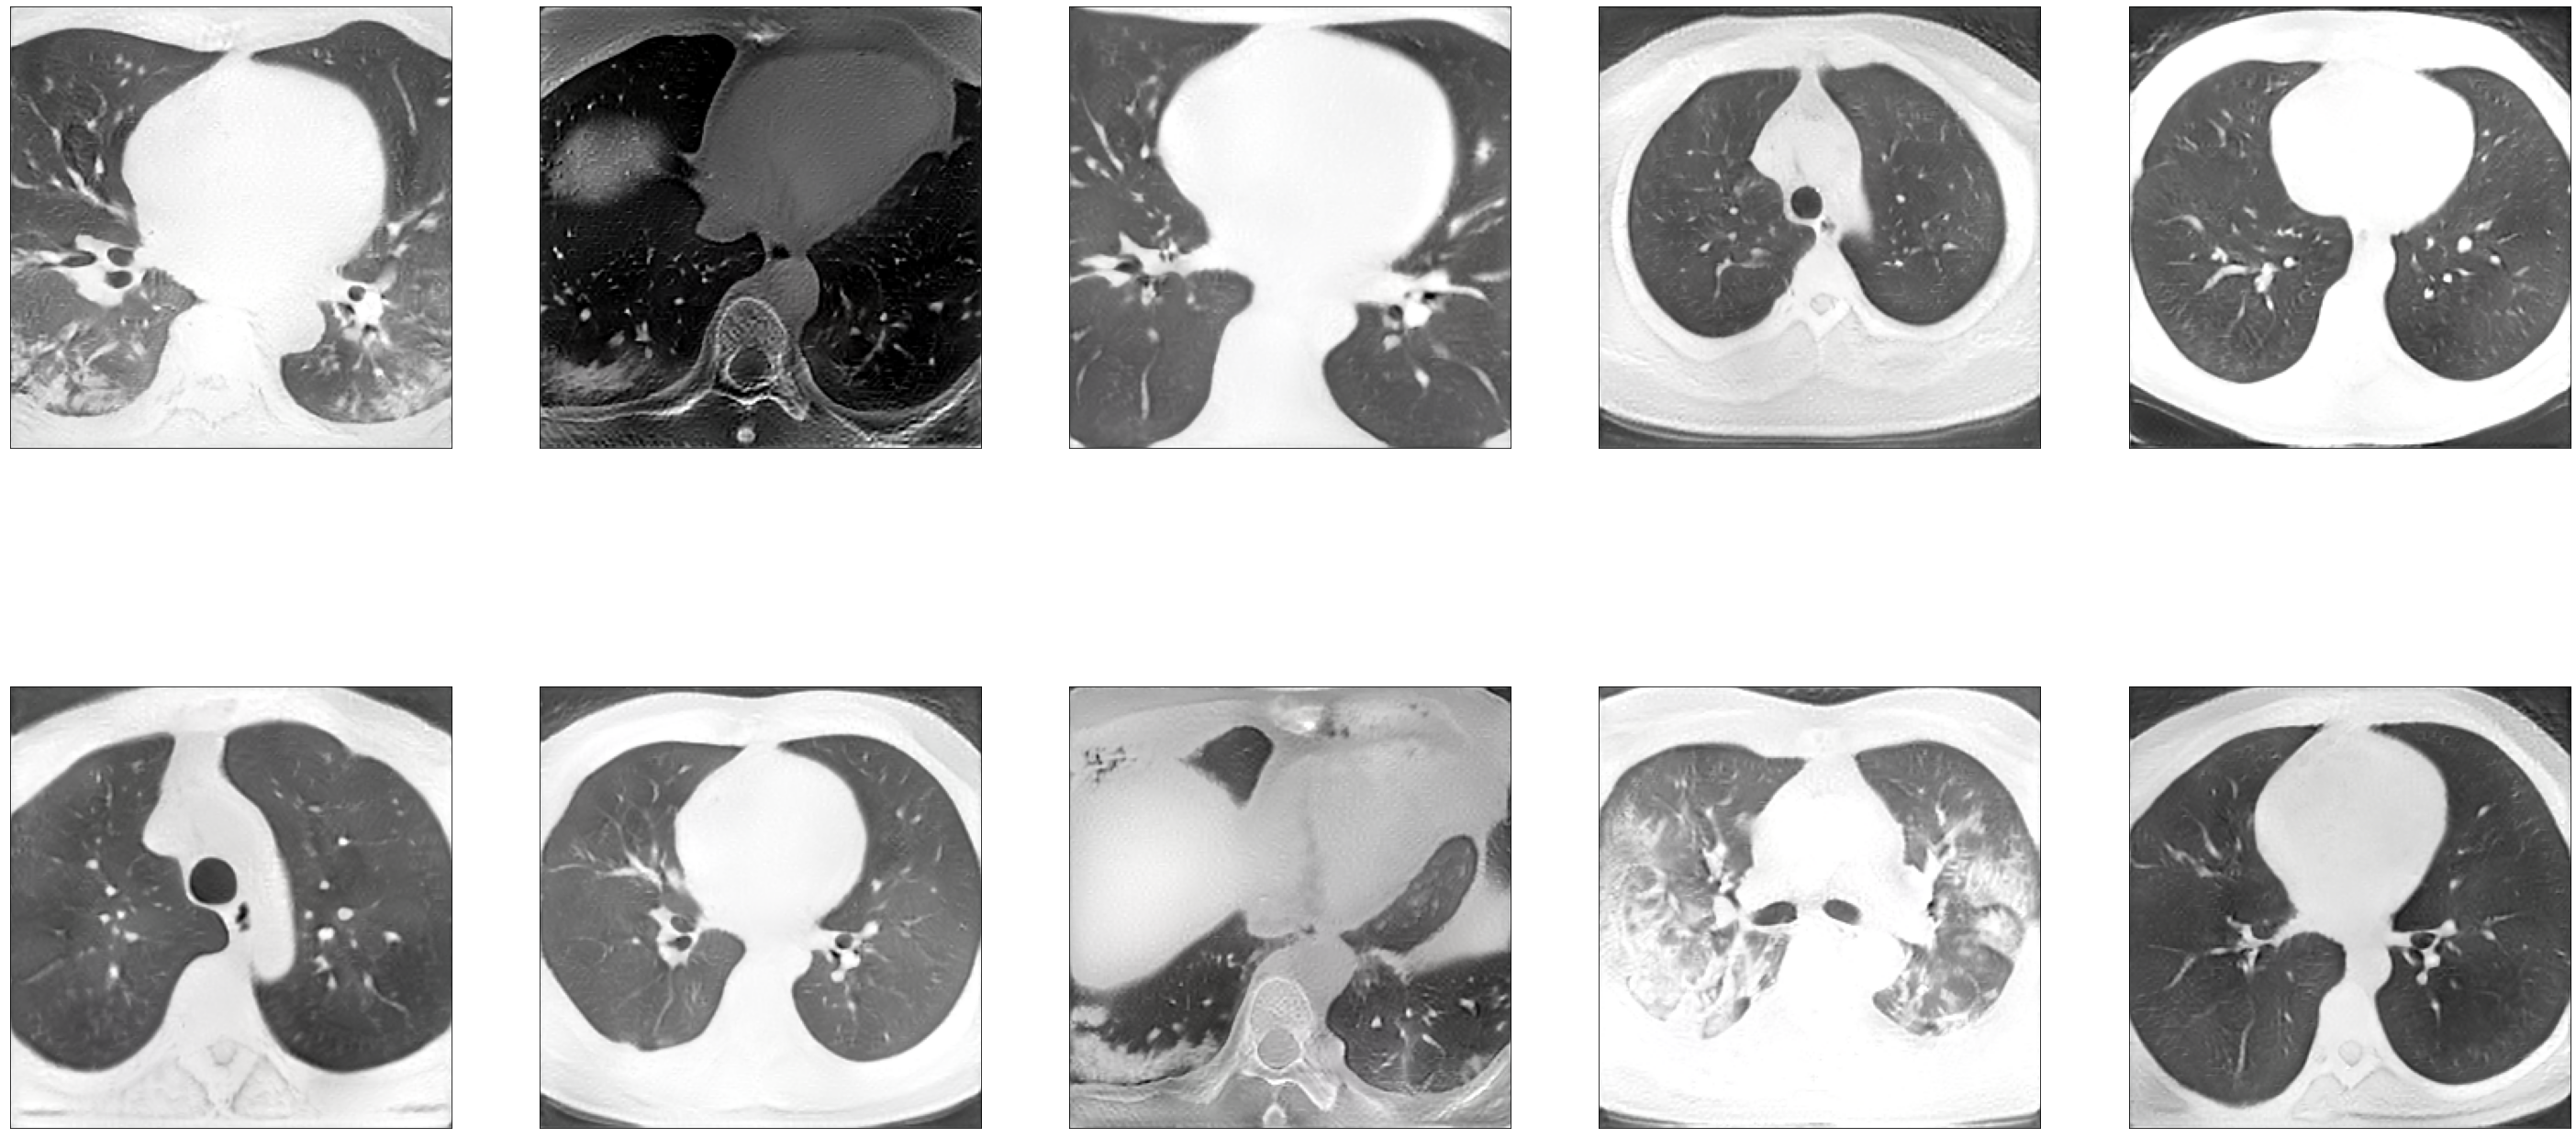

In [11]:
import matplotlib.pyplot as plt
import numpy as np
path = "sample/"
plot_size=10

# your images in an array
imgs = loadImages(path)
images = []
for ii in range(0,len(imgs),50):
    # you can show every image
    images.append(np.array(imgs[ii]))

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(50, 25))

for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx])